This project builds and evaluates a next-day price direction model for NVIDIA (NVDA) using daily OHLCV data. The goal is to answer a practical question: when is it worth taking a long position for the next trading day? We approach this as a supervised classification task and compare two tree-based methods—Random Forest and XGBoost—on both raw prices and simple, causal technical features.

Data & label
1.   Source: yfinance adjusted daily OHLCV for NVDA.
2.   Target: 1 if tomorrow’s close > today’s close, else 0.


Features

1. Baseline: raw Open, High, Low, Close, Volume.

2. Engineered (causal at decision time): rolling Close/MA ratios and past up-day counts (“Trend”) over multiple horizons (2, 5, 60, 250, 1000).

Methodology

1. Train classifiers to output probabilities; convert to signals with a tunable probability threshold (trade-off between hit rate and number of trades).

2. Use an expanding, walk-forward backtest (no look-ahead): repeatedly train on past data and test strictly on future slices.

Evaluation

1. Classification: Precision, Recall, F1, Coverage (how often we trade) and confusion matrix.

2. Strategy proxy: simple gross next-day return when a long signal is issued (no costs), plus average return per trade.

3. Threshold sweeps to visualize precision vs. coverage.

1. Install & imports

In [27]:
# ------------------------------------------------------------
# Step 1) Imports & reproducibility
# ------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier

RNG_SEED = 1              # fixed seed so results are reproducible
np.random.seed(RNG_SEED)  # set numpy's seed (tree libs also use random_state)


2. Download NVDA data (adjusted) & quick peek

In [28]:
# ------------------------------------------------------------
# Step 2) Download NVDA (adjusted OHLCV), create Target label
# ------------------------------------------------------------
# auto_adjust=True returns split/dividend-adjusted prices to avoid artificial jumps
nvda = yf.Ticker("NVDA").history(period="max", auto_adjust=True)

# keep a clean OHLCV (OHLCV: Open, High, Low, Close, Volume for each day (from yfinance)) subset
nvda = nvda[["Open","High","Low","Close","Volume"]].copy()

# create tomorrow's close (shift -1) and direction label: 1 if tomorrow > today else 0
nvda["Tomorrow"] = nvda["Close"].shift(-1)
nvda["Target"]   = (nvda["Tomorrow"] > nvda["Close"]).astype(int)

# the last row has Tomorrow=NaN, drop it
nvda = nvda.dropna(subset=["Tomorrow"]).copy()

# quick peek
print("NVDA (head):")
print(nvda.head(), "\n")
print("NVDA (tail):")
print(nvda.tail(), "\n")

NVDA (head):
                               Open      High       Low     Close      Volume  \
Date                                                                            
1999-01-22 00:00:00-05:00  0.040116  0.044772  0.035579  0.037609  2714688000   
1999-01-25 00:00:00-05:00  0.040594  0.042026  0.037609  0.041549   510480000   
1999-01-26 00:00:00-05:00  0.042026  0.042862  0.037728  0.038325   343200000   
1999-01-27 00:00:00-05:00  0.038444  0.039400  0.036295  0.038206   244368000   
1999-01-28 00:00:00-05:00  0.038206  0.038444  0.037848  0.038086   227520000   

                           Tomorrow  Target  
Date                                         
1999-01-22 00:00:00-05:00  0.041549       1  
1999-01-25 00:00:00-05:00  0.038325       0  
1999-01-26 00:00:00-05:00  0.038206       0  
1999-01-27 00:00:00-05:00  0.038086       0  
1999-01-28 00:00:00-05:00  0.036295       0   

NVDA (tail):
                                 Open        High         Low       Close  \
Date 

3. Quick close chart

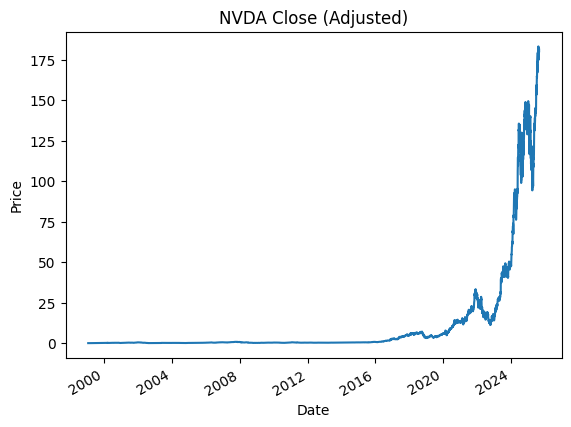

In [29]:
# ------------------------------------------------------------
# Step 3) Quick close chart for context
# ------------------------------------------------------------
ax = nvda["Close"].plot(title="NVDA Close (Adjusted)")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
plt.show()


4. A tiny baseline holdout test (sanity check)

In [30]:
# ------------------------------------------------------------
# Step 4) Tiny baseline: RF on raw OHLCV with a simple holdout
# ------------------------------------------------------------
# NOTE: this is just a sanity check; the real eval is the walk-forward backtest later
predictors_raw = ["Close","Volume","Open","High","Low"]

train_raw = nvda.iloc[:-100]   # train on everything but last 100 rows
test_raw  = nvda.iloc[-100:]   # test on the most recent 100 rows

rf_quick = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=100,
    random_state=RNG_SEED,
    n_jobs=-1
)
rf_quick.fit(train_raw[predictors_raw], train_raw["Target"])
pred_raw = rf_quick.predict(test_raw[predictors_raw])

prec_quick = precision_score(test_raw["Target"], pred_raw)
print(f"Quick holdout precision (RF, raw OHLCV): {prec_quick:.3f}\n")

Quick holdout precision (RF, raw OHLCV): 0.640



5) Rolling features (momentum ratios + past trend)

In [32]:
# ------------------------------------------------------------
# Step 5) Feature engineering: momentum ratios + past trend
# ------------------------------------------------------------
# We build two features per horizon h:
#  1) Close Ratio_h  = Close / rolling_mean(Close, h)      --> normalized momentum
#  2) Trend_h        = sum of past up-days over last h days --> recent win-rate
# We use shift(1) before rolling on Target to avoid look-ahead bias.

horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for h in horizons:
    # rolling mean for the ratio
    rolling_mean = nvda["Close"].rolling(h).mean()
    ratio_col = f"Close Ratio_{h}"
    nvda[ratio_col] = nvda["Close"] / rolling_mean

    # past up-day trend (shift so "today" isn't included)
    trend_col = f"Trend_{h}"
    nvda[trend_col] = nvda["Target"].shift(1).rolling(h).sum()

    new_predictors += [ratio_col, trend_col]

# with 1000-day windows, early rows are NaN; drop them for a clean ML dataset
data_ml = nvda.dropna().copy()
print("First usable date after feature windows:", data_ml.index[0].date(), "\n")

First usable date after feature windows: 2003-01-15 



6) Backtesting helpers (probabilities → labels, walk-forward backtest, summaries)

In [20]:
# ------------------------------------------------------------
# Step 6) Backtesting helpers (prob thresholding, fit/predict, WF backtest, summaries)
# ------------------------------------------------------------
def proba_to_labels(p: pd.Series, threshold: float = 0.60) -> pd.Series:
    """
    Convert positive-class probabilities to {0,1} using a fixed threshold.
    Higher threshold = fewer but higher-confidence positive calls.
    """
    return (p >= threshold).astype(int)

def fit_predict_proba(model, train_df: pd.DataFrame, test_df: pd.DataFrame, predictors: list) -> pd.Series:
    """
    Fit model on train_df and return positive-class probabilities on test_df.
    Falls back to scaling decision_function if predict_proba is unavailable.
    """
    model.fit(train_df[predictors], train_df["Target"])
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(test_df[predictors])[:, 1]
    else:
        s = model.decision_function(test_df[predictors])
        p = (s - s.min()) / (s.max() - s.min() + 1e-9)
    return pd.Series(p, index=test_df.index, name="proba")

def backtest_models(
    data: pd.DataFrame,
    models: dict,
    predictors: list,
    start: int = 2500,
    step: int = 250,
    threshold: float = 0.60
) -> dict:
    """
    Expanding-window walk-forward backtest:
      For i in [start, ..., n, step]:
        - train = data[:i]
        - test  = data[i:i+step]
    Returns dict[name] -> DataFrame with columns ['Target','proba','pred'] concatenated over folds.
    """
    results = {name: [] for name in models}

    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test  = data.iloc[i:i+step].copy()
        if test.empty:
            break

        for name, est in models.items():
            proba = fit_predict_proba(est, train, test, predictors)
            pred  = proba_to_labels(proba, threshold)
            chunk = pd.DataFrame({
                "Target": test["Target"].astype(int),
                "proba":  proba,
                "pred":   pred
            })
            results[name].append(chunk)

    # concatenate each model's folds
    for name in results:
        if results[name]:
            results[name] = pd.concat(results[name]).sort_index()
        else:
            results[name] = pd.DataFrame(columns=["Target","proba","pred"])

    return results

def summarize_results(results: dict) -> pd.DataFrame:
    """
    Compute Precision, Recall, F1, Coverage (% of positive predictions), and confusion matrix counts.
    Sorted by Precision by default; adjust if you prefer another metric.
    """
    rows = []
    for name, df in results.items():
        if df.empty:
            rows.append({
                "Model": name, "Precision": np.nan, "Recall": np.nan, "F1": np.nan,
                "Coverage_%": np.nan, "TP": 0, "FP": 0, "TN": 0, "FN": 0, "N": 0
            })
            continue

        y_true = df["Target"].astype(int).values
        y_pred = df["pred"].astype(int).values

        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
        cov  = y_pred.mean()
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

        rows.append({
            "Model": name,
            "Precision": round(prec, 4),
            "Recall": round(rec, 4),
            "F1": round(f1, 4),
            "Coverage_%": round(100 * cov, 2),
            "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn),
            "N": int(len(y_true))
        })

    return pd.DataFrame(rows).sort_values(by="Precision", ascending=False).reset_index(drop=True)

def attach_simple_pnl(df_preds: pd.DataFrame, prices: pd.DataFrame) -> pd.DataFrame:
    """
    Simple gross PnL (no costs): decide after close at t, hold close->close t+1 only when pred==1.
    Adds 'next_return' and 'strategy_return' columns to df_preds.
    """
    next_ret = prices["Close"].pct_change().shift(-1)  # r_{t+1} = Close_{t+1}/Close_t - 1
    out = df_preds.copy()
    out["next_return"] = next_ret.reindex(out.index)
    out["strategy_return"] = out["pred"] * out["next_return"]
    return out

def summarize_pnl(results: dict, prices: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate gross total return, average return per trade, and number of trades per model.
    """
    rows = []
    for name, df in results.items():
        with_pnl = attach_simple_pnl(df, prices)
        total = np.nansum(with_pnl["strategy_return"].values)     # sum of daily strategy returns
        avg   = np.nanmean(with_pnl["strategy_return"].values)    # mean per day (only non-NaN days)
        trades= int(with_pnl["pred"].sum())                       # how many positive calls (trades)
        rows.append({
            "Model": name,
            "Trades": trades,
            "Total_Return_%": round(100 * total, 2),
            "Avg_Trade_Return_%": round(100 * avg, 3)
        })
    return pd.DataFrame(rows).sort_values(by="Total_Return_%", ascending=False).reset_index(drop=True)

7) Define models (Random Forest vs XGBoost)

In [33]:
# ------------------------------------------------------------
# Step 7) Define models: Random Forest vs XGBoost
# ------------------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=50,
    random_state=RNG_SEED,
    n_jobs=-1
)

xgb = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    eval_metric="logloss",
    random_state=RNG_SEED,
    n_jobs=-1,
    tree_method="hist"   # fast & robust on CPU
)

models = {"RandomForest": rf, "XGBoost": xgb}

8) Run the walk-forward comparison (engineered features for both)

In [34]:
# ------------------------------------------------------------
# Step 8) Walk-forward comparison using engineered features
# ------------------------------------------------------------
predictors = new_predictors    # use the engineered features from Step 5

START = 2500                   # first test fold starts after 2,500 training rows
STEP  = 250                    # each fold tests the next 250 rows
THRESHOLD = 0.60               # probability cut to label 1

results = backtest_models(
    data=data_ml,
    models=models,
    predictors=predictors,
    start=START,
    step=STEP,
    threshold=THRESHOLD
)

metrics_table = summarize_results(results)
pnl_table     = summarize_pnl(results, prices=data_ml[["Close"]])

print("Classification metrics (engineered features):")
print(metrics_table, "\n")

print("Simple gross PnL summary (engineered features):")
print(pnl_table, "\n")

Classification metrics (engineered features):
          Model  Precision  Recall      F1  Coverage_%   TP   FP    TN    FN  \
0  RandomForest     0.5810  0.0959  0.1647        8.90  165  119  1353  1555   
1       XGBoost     0.5743  0.3012  0.3951       28.26  518  384  1088  1202   

      N  
0  3192  
1  3192   

Simple gross PnL summary (engineered features):
          Model  Trades  Total_Return_%  Avg_Trade_Return_%
0       XGBoost     902          387.26               0.121
1  RandomForest     284          157.69               0.049 



9) Precision/coverage vs threshold for XGBoost (pick your operating point)

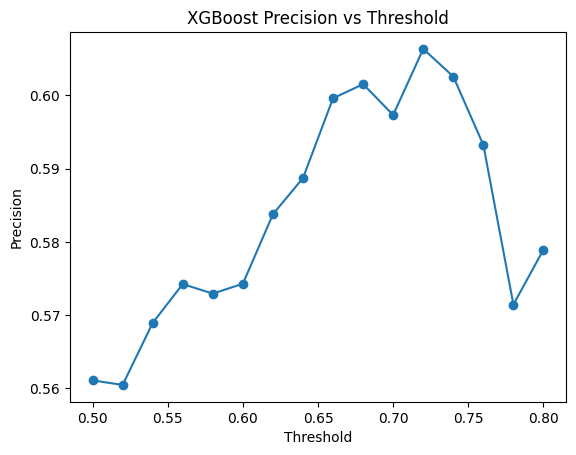

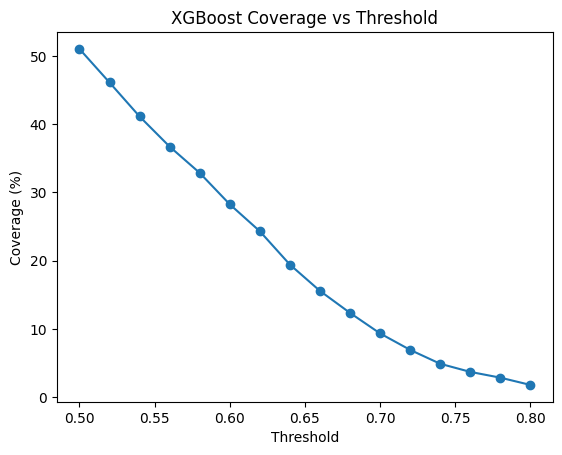

In [35]:
# ------------------------------------------------------------
# Step 9) Threshold tuning curves for XGBoost
# ------------------------------------------------------------
# We sweep thresholds and show how precision and coverage move.
xgb_df = results["XGBoost"]
y_true = xgb_df["Target"].values
p      = xgb_df["proba"].values

ths = np.linspace(0.50, 0.80, 16)
precisions, coverages = [], []

for t in ths:
    yhat = (p >= t).astype(int)
    precisions.append(precision_score(y_true, yhat, zero_division=0))
    coverages.append(yhat.mean())

plt.figure()
plt.plot(ths, precisions, marker="o")
plt.title("XGBoost Precision vs Threshold")
plt.xlabel("Threshold"); plt.ylabel("Precision")
plt.show()

plt.figure()
plt.plot(ths, np.array(coverages) * 100, marker="o")
plt.title("XGBoost Coverage vs Threshold")
plt.xlabel("Threshold"); plt.ylabel("Coverage (%)")
plt.show()

10) Compare to raw OHLCV features (sanity check on feature value)

In [36]:
# ------------------------------------------------------------
# Step 10) Compare to RAW OHLCV features
# ------------------------------------------------------------
# Re-run the same backtest using only raw OHLCV to quantify the value of engineering.
models_raw = {"RandomForest_raw": rf, "XGBoost_raw": xgb}

results_raw = backtest_models(
    data=data_ml,  # same date span for fairness
    models=models_raw,
    predictors=["Close","Volume","Open","High","Low"],
    start=START,
    step=STEP,
    threshold=THRESHOLD
)

metrics_raw = summarize_results(results_raw)
pnl_raw     = summarize_pnl(results_raw, prices=data_ml[["Close"]])

print("Classification metrics (RAW OHLCV):")
print(metrics_raw, "\n")

print("Simple gross PnL summary (RAW OHLCV):")
print(pnl_raw, "\n")

Classification metrics (RAW OHLCV):
              Model  Precision  Recall      F1  Coverage_%   TP   FP    TN  \
0  RandomForest_raw     0.5551  0.1552  0.2426       15.07  267  214  1258   
1       XGBoost_raw     0.5293  0.2733  0.3604       27.82  470  418  1054   

     FN     N  
0  1453  3192  
1  1250  3192   

Simple gross PnL summary (RAW OHLCV):
              Model  Trades  Total_Return_%  Avg_Trade_Return_%
0       XGBoost_raw     888          189.52               0.059
1  RandomForest_raw     481           79.39               0.025 



# Conclusion

**Goal:** Predict NVDA’s next-day direction and convert model probabilities into actionable, one-day long signals.  
**Method:** Causal rolling features + expanding walk-forward backtest; compare Random Forest vs XGBoost; classify with a probability threshold.

## Key findings
- **XGBoost + engineered features** is the clear winner.
  - **Precision:** 0.574  
  - **Recall:** 0.301  
  - **F1:** 0.395  
  - **Coverage:** 28.26% of days  
  - **Gross PnL (close→close):** **+387.3%** over **902** trades (avg “trade-day” ≈ **+0.121%**)
- **Random Forest + engineered features**
  - Precision 0.581, Recall 0.096, F1 0.165, Coverage 8.90%  
  - Gross PnL **+157.7%** over 284 trades (avg “trade-day” ≈ **+0.049%**)
- **Engineered rolling features materially help** (vs raw OHLCV):
  - XGBoost raw → **+189.5%**; with features → **+387.3%**
- **Threshold trade-off (XGBoost):** raising the cutoff increases precision and reduces coverage; pick based on **net** out-of-sample PnL, not just hit rate.

## What this means
- Both models beat a naive “always up” precision by a few points, but **XGBoost captures far more winners** (higher recall at similar precision), leading to many more profitable opportunities and higher aggregate PnL.
- Simple, causal momentum/trend features across multiple horizons give the trees useful, time-aware context.

## Caveats
- PnL is **gross**, **close→close**, and **not compounded** → optimistic.  
- No transaction costs or slippage modeled.  
- Single-asset results can be **regime-dependent**.

## Next steps
1. Use **next-day open→close** returns, add **transaction costs**, and plot a **compounded equity curve** (CAGR, max DD, Sharpe).  
2. Tune **XGBoost hyperparameters** and the **probability threshold** with **time-series CV** inside training folds.  
3. Test robustness by **era** and try additional causal features (volatility, gaps, breakouts) and **probability calibration**.

**Bottom line:** With simple causal features and a proper walk-forward backtest, **XGBoost outperforms Random Forest** on NVDA next-day direction, delivering higher recall and substantially better gross PnL. Make execution more realistic and add costs before treating it as tradable.
